In [1]:
import os
import gc
import time
import copy
import optuna

from pathlib import Path

import numpy as np, pandas as pd, polars as pl

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier

from sklearn.utils import resample

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgb, catboost as cb, xgboost as xgb

from optuna.samplers import TPESampler

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
# from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import NearMiss, TomekLinks
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from torch import nn
import timm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from torch.utils.data import Dataset,DataLoader
import h5py
from io import BytesIO
from PIL import Image
from torchvision.transforms import v2
import os
from sklearn.model_selection import GroupShuffleSplit , train_test_split, StratifiedGroupKFold
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score,roc_curve,auc
import gc
import random
from torchvision.ops import sigmoid_focal_loss
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
MODEL_NAME = 'efficientnet_b3'
CNN_EMBEDDINGS_SIZE = 1
DROPOUT_RATE = 0.6
TABULAR_SHARE = 512
IMAGE_INPUT_SHAPE = 224
BATCH_SIZE = 32
VAL_BATCH_SIZE = 64
EPOCHS = 5
BEST_WEIGHT = '/kaggle/input/lets-go-neural-8-image-only-state-dict/fullmodel2_epoch1loss0.130auc0.881pauc0.158.pth'
SEED = 42
ALPHA = 0.01
GAMMA = 2
FULL = 0.025

# IMAGE PREDICTIONS

In [4]:
#EFFNET V1B0
!python /kaggle/input/isic-script-inference-effnetv1b0-f313ae/main.py /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
!mv submission.csv submission_effnetv1b0.csv

BEST_WEIGHT = /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


In [5]:
#TARGET 3
!python /kaggle/input/isic-2024-pl-submission-script-and-preds/pl_submission.py
!mv submission.csv submission_image3.csv

/kaggle/input/isic-2024-pl-submission-script-and-preds/pl_submission.py:25: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_meta = pd.read_csv(BASE_DATA_DIR + "train-metadata.csv")


In [6]:
# #EVA02
# !python /kaggle/input/isic-script-inference-eva02/main.py /kaggle/input/isic-pytorch-training-baseline-eva02/AUROC0.5177_Loss0.2829_epoch7.bin
# !mv submission.csv submission_eva02.csv

In [7]:
# #EDGENEXT
# !python /kaggle/input/isic-script-inference-edgenext/main.py /kaggle/input/isic-pytorch-training-edgenext/Final_model.bin
# !mv submission.csv submission_edgenext.csv

# DATA PREPROCESS

In [8]:
root = Path('/kaggle/input/isic-2024-challenge')

train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv'
subm_path = root / 'sample_submission.csv'

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',                 # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',                # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                      # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',                # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',           # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',                 # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',                  # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',              # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',           # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',           # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',           # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',       # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',       # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',                 # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',                 # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',              # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',         # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',             # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',            # border_complexity       + lesion_shape_index
    'color_contrast_index',              # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',                   # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',            # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',               # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',                  # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',       # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',             # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',          # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',    # tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',        # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',              # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',          # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',         # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',    # tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',             # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',           # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                       # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',           # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',               # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',           # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',           # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
image_cols = ["target_3","target_effnetv1b0"] # ,"target_eva02"] # ,"target_edgenext"]

#norm_cols += image_cols
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [9]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

In [10]:
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')  
    
    # effnetv1b0
    df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")
    df_train = df_train.reset_index(drop=True)
    df_eff = df_eff.reset_index(drop=True)
    df_train["target_effnetv1b0"] = df_eff["target_effnetv1b0"]
    df_eff = pd.read_csv("submission_effnetv1b0.csv")
    df_test = df_test.reset_index(drop=True)
    df_eff = df_eff.reset_index(drop=True)
    df_test["target_effnetv1b0"] = df_eff["target"]
        
    # target 3
    df_image_3 = pd.read_csv("/kaggle/input/isic-2024-pl-submission-script-and-preds/train_preds.csv")
    df_train = df_train.reset_index(drop=True)
    df_image_3 = df_image_3.reset_index(drop=True)
    df_train["target_3"] = df_image_3["pred"]
    df_3 = pd.read_csv("submission_image3.csv")
    df_test = df_test.reset_index(drop=True)
    df_image_3 = df_image_3.reset_index(drop=True)
    df_test["target_3"] = df_3["target"]
    
#     #eva02
#     df_eva = pd.read_csv("/kaggle/input/isic-inference-eva02-for-training-data/train_eva02.csv")
#     df_train = df_train.reset_index(drop=True)
#     df_eva = df_eva.reset_index(drop=True)
#     df_eva = df_eva[["target_eva02"]]
#     df_train["target_eva02"] = df_eva["target_eva02"]
#     df_eva = pd.read_csv("submission_eva02.csv")
#     df_test = df_test.reset_index(drop=True)
#     df_eva = df_eva.reset_index(drop=True)
#     df_test["target_eva02"] = df_eva["target"]
    
#     #edgenext
#     df_ednx = pd.read_csv("/kaggle/input/isic-inference-edgenext-for-training-data/train_edgenext.csv")
#     df_train = df_train.reset_index(drop=True)
#     df_ednx = df_ednx.reset_index(drop=True)
#     df_ednx = df_ednx[['target_edgenext']]
#     df_train['target_edgenext'] = df_ednx['target_edgenext']
#     df_ednx = pd.read_csv("submission_edgenext.csv")
#     df_test = df_test.reset_index(drop=True)
#     df_ednx = df_ednx.reset_index(drop=True)
#     df_test ["target_edgenext"] = df_ednx['target']

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [11]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [12]:
df_train = read_data(train_path)
df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path, index_col=id_col)

df_train, df_test = preprocess(df_train, df_test)
df_train

/tmp/ipykernel_34/3271317884.py:16: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")


,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,onehot_39,onehot_40,onehot_41,onehot_42,onehot_43,onehot_44,onehot_45,onehot_46,target_effnetv1b0,target_3
0,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,...,0,0,0,0,0,1,0,0,0.576453,0.000046
1,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,...,0,0,0,0,0,1,0,0,0.562958,0.028392
2,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,...,0,0,0,0,0,1,0,0,0.021381,0.000174
3,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,...,0,1,0,0,0,0,0,0,0.608011,0.002001
4,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,...,0,0,0,0,0,1,0,0,0.443609,0.000145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,14.944666,...,0,0,1,0,0,0,0,0,0.806214,0.013333
401055,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,16.026870,...,0,0,0,0,0,1,0,0,0.160842,0.001346
401056,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,12.364397,...,0,0,0,0,1,0,0,0,0.125984,0.005390
401057,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,9.564721,...,0,0,0,0,0,0,1,0,0.141543,0.001180


In [13]:
#they are detected at the first run
least_important_features = ['onehot_32', 'onehot_6', 'onehot_33', 'onehot_30', 'onehot_26', 'onehot_22', 'onehot_36', 'onehot_4']
#they are detected after the least_important_features are removed and it has increased cv score also so I add it
#least_important_features_2 = ['onehot_17', 'onehot_42', 'onehot_29', 'onehot_13', 'onehot_25']
#least_important_features += least_important_features_2
df_train.drop(columns =least_important_features,inplace = True)
for feature in least_important_features:
    cat_cols.remove(feature)
    feature_cols.remove(feature)

In [14]:
def preprocess2(df_train,df_test):
    
    new_train = df_train.copy()
    new_test = df_test.copy()
    
    
#     imputing train
    imputer_cat = SimpleImputer(strategy='most_frequent')
    imputer_num = SimpleImputer(strategy='median')
    new_train[cat_cols]=imputer_cat.fit_transform(new_train[cat_cols])
    new_train[cat_cols] = new_train[cat_cols].apply(lambda x: x.astype('category'))
    new_train[list(set(feature_cols)-set(cat_cols))]=imputer_num.fit_transform(new_train[list(set(feature_cols)-set(cat_cols))])

# #     cat_cols encoding
#     encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan)
#     new_train[cat_cols] = encoder.fit_transform(new_train[cat_cols])
#     new_test[cat_cols] = encoder.transform(new_test[cat_cols])
    
#     imputing test
    new_test[cat_cols]=imputer_cat.transform(new_test[cat_cols])
    new_test[cat_cols] = new_test[cat_cols].apply(lambda x: x.astype('category'))
    new_test[list(set(feature_cols)-set(cat_cols))]=imputer_num.transform(new_test[list(set(feature_cols)-set(cat_cols))])

#     removing num_cols with 0 std
#     zero_std_cols = [col for col in num_cols if new_train[col].std()==0]
#     new_train.drop(columns=zero_std_cols,inplace=True)
#     new_test.drop(columns=zero_std_cols,inplace=True)
#     num_cols = [col for col in num_cols if col not in zero_std_cols]
#     f_cols = cat_cols+num_cols
    
#     get cat_sizes for embeddings
#     cat_sizes = [len(set(new_train[col])) for col in cat_cols]
#     for col in cat_cols:
#         print(set(new_test[col])-set(new_train[col]))
    
#     normalizing train and test
#     means = pd.Series([new_train[col].mean() for col in num_cols],index=num_cols)
#     stds = pd.Series([new_train[col].std() for col in num_cols],index=num_cols)
#     new_train[num_cols] =( new_train[num_cols]-means)/stds
#     new_test[num_cols] =( new_test[num_cols]-means)/stds

#     reset index
#     new_train = new_train.reset_index(drop=True)
    
    
    return new_train,new_test

In [15]:
df_train,df_test = preprocess2(df_train,df_test)

In [16]:
df_train[feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Columns: 192 entries, age_approx to onehot_46
dtypes: category(39), float64(153)
memory usage: 483.1 MB


***drop least important features with feature importance(code at the last of the notebook before test predictions)***

In [17]:
df_train[target_col]

0         0
1         0
2         0
3         0
4         0
         ..
401054    0
401055    0
401056    0
401057    0
401058    0
Name: target, Length: 401059, dtype: int64

# MODEL INITIALIZATION

In [18]:
class FullDataset(Dataset):
    def __init__(self,df_train):
        self.x = torch.tensor(df_train[feature_cols].to_numpy(),dtype=torch.float)
        self.y = torch.tensor(df_train[target_col].to_numpy(),dtype=torch.float)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        to_return = {
            'X':self.x[idx],
            'y':self.y[idx]
        }
        return to_return

In [19]:
class FullDataset_test(Dataset):
    def __init__(self,df_train):
        self.x = torch.tensor(df_train[feature_cols].to_numpy(),dtype=torch.float)
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        to_return = {
            'X':self.x[idx],
        }
        return to_return

In [20]:
class FullModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mod = nn.Sequential(
        nn.Linear(192,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,1))
    def forward(self,x):
#         print(x.shape)
#         print_gpu_usage()
        return self.mod(x)
FullModel()

FullModel(
  (mod): Sequential(
    (0): Linear(in_features=192, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

# CROSS VALIDATION

In [21]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
# print(f'train_size before: {tabular_train_copy.shape[0]}')
sgkf = StratifiedGroupKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(sgkf.split(df_train, df_train[target_col], df_train[group_col])):
    tabular_val = df_train.copy().iloc[test_index].reset_index(drop=True)
    tabular_train = df_train.copy().iloc[train_index].reset_index(drop=True)
    break


In [22]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
train_dataset = FullDataset(tabular_train)
test_dataset = FullDataset_test(df_test)
val_dataset = FullDataset(tabular_val)
full_train = FullDataset(df_train)

In [23]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset,batch_size = VAL_BATCH_SIZE,shuffle=False,num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset,batch_size = VAL_BATCH_SIZE,shuffle=False,num_workers=os.cpu_count())
full_train_loader = DataLoader(full_train,batch_size = BATCH_SIZE,shuffle=True,num_workers=os.cpu_count())

In [24]:
len(next(iter(train_loader)))

2

In [25]:
def pauc_metric(y_true, y_scores, tpr_threshold=0.8):

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Create a mask for TPR values above the threshold
    mask = tpr >= tpr_threshold

    # Filter FPR and TPR values based on the mask
    fpr_above_threshold = fpr[mask]
    tpr_above_threshold = tpr[mask]

    # Calculate the partial AUC
    try:
        partial_auc = auc(fpr_above_threshold, tpr_above_threshold)
    except:
        return 0

    # Normalize the partial AUC
    pauc = partial_auc * (1 - tpr_threshold)

    return pauc 

In [26]:
def train_epoch(model,train_loader,DEVICE):
    model.train()
    ys=[]
    preds=[]
    torch.cuda.empty_cache()
    for i,data in tqdm(enumerate(train_loader),total=len(train_loader)):
        y = data['y']
        ys.append(y)
        y=y.to(DEVICE)
        X = data['X'].to(DEVICE)
        y_pred = model(X)
        preds.append(y_pred.squeeze().cpu())
        loss = loss_fn(y_pred.squeeze(),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del X,data
        scheduler.step()
    torch.cuda.empty_cache()
    gc.collect()
    model.eval()
    with torch.inference_mode():
        ys = torch.cat(ys)
        preds = torch.cat(preds)
        pred_probs = nn.Sigmoid()(preds)
        loss = loss_fn(preds,ys)
        auc = roc_auc_score(ys,pred_probs)
        pauc = pauc_metric(ys,pred_probs)
    return loss,auc,pauc

In [27]:
def val_epoch(model,val_loader,DEVICE):
    model.eval()
    with torch.inference_mode():
        ys=[]
        preds=[]
        torch.cuda.empty_cache()
        for i,data in tqdm(enumerate(val_loader),total=len(val_loader)):
            y = data['y']
            ys.append(y)
            y=y.to(DEVICE)
            X = data['X'].to(DEVICE)
            y_pred =  model(X)
            preds.append(y_pred.squeeze().cpu())
            del X,data
        torch.cuda.empty_cache()
        gc.collect()
        ys = torch.cat(ys)
        preds = torch.cat(preds)
        pred_probs = nn.Sigmoid()(preds)
        loss = loss_fn(preds,ys)
        auc = roc_auc_score(ys,pred_probs)
        pauc = pauc_metric(ys,pred_probs)
        
    return loss,auc,pauc

In [28]:
def predict(model,test_loader,DEVICE):
    model.eval()
    with torch.inference_mode():
        preds=[]
        torch.cuda.empty_cache()
        for i,data in tqdm(enumerate(test_loader),total=len(test_loader)):
            X = data['X'].to(DEVICE)
            y_pred = model(X)
            preds.append(y_pred.squeeze().detach().cpu())
            del X,y_pred,data
            if i%50==0: gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        preds = torch.cat(preds)
        pred_probs = nn.Sigmoid()(preds)
        
    return pred_probs

In [29]:
def train_model(model,train_loader,val_loader,DEVICE,epochs=5):
    best_auc = -2
    best_pauc = -2
    best_loss = np.inf
    train_loss,val_loss=[],[]
    train_auc,val_auc=[],[]
    train_pauc,val_pauc=[],[]
    for e in (range(epochs)):
        print(f'## Epoch: {e} ongoing ---------------')
        t_loss,t_auc,t_pauc = train_epoch(model,train_loader,DEVICE)
        v_loss,v_auc,v_pauc = val_epoch(model,val_loader,DEVICE)
        train_loss.append(t_loss)
        val_loss.append(v_loss)
        train_auc.append(t_auc)
        val_auc.append(v_auc)
        train_pauc.append(t_pauc)
        val_pauc.append(v_pauc)
        print(f'Epoch: {e}, Train loss: {t_loss}, Train auc: {t_auc}, Train pauc: {t_pauc} | Val loss: {v_loss}, Val auc: {v_auc}, Val pauc: {v_pauc}')
#         if v_pauc>=best_pauc or v_auc>=best_auc or v_loss<=best_loss:
        best_pauc,best_auc,best_loss = max(best_pauc,v_pauc),max(best_auc,v_auc),min(best_loss,v_loss)
        print('Saving model')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        },f'fullmodel2_epoch{e}loss{v_loss:.3f}auc{v_auc:.3f}pauc{v_pauc:.3f}.pth')
    return train_loss,val_loss,train_auc,val_auc,train_pauc,val_pauc,model

In [30]:
def train_model_full(model,train_loader,DEVICE,epochs=5):
    best_auc = -2
    best_pauc = -2
    best_loss = np.inf
    train_loss,val_loss=[],[]
    train_auc,val_auc=[],[]
    train_pauc,val_pauc=[],[]
    for e in (range(epochs)):
        print(f'## Epoch: {e} ongoing ---------------')
        t_loss,t_auc,t_pauc = train_epoch(model,train_loader,DEVICE)
#         v_loss,v_auc,v_pauc = val_epoch(model,val_loader,DEVICE)
        train_loss.append(t_loss)
#         val_loss.append(v_loss)
        train_auc.append(t_auc)
#         val_auc.append(v_auc)
        train_pauc.append(t_pauc)
#         val_pauc.append(v_pauc)
        print(f'Epoch: {e}, Train loss: {t_loss}, Train auc: {t_auc}, Train pauc: {t_pauc}')
#         if v_pauc>=best_pauc or v_auc>=best_auc or v_loss<=best_loss:
#         best_pauc,best_auc,best_loss = max(best_pauc,v_pauc),max(best_auc,v_auc),min(best_loss,v_loss)
        print('Saving model')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        },f'full_train_model2_epoch{e}loss{t_loss:.3f}auc{t_auc:.3f}pauc{t_pauc:.3f}.pth')
    return train_loss,val_loss,train_auc,val_auc,train_pauc,val_pauc,model

In [31]:
df_train[feature_cols].isna().sum().sum()

0

In [32]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
full_model = FullModel()
full_model = full_model.to(DEVICE)
full_model.load_state_dict(torch.load('/kaggle/input/latest-state-dict/fullmodel2_epoch24loss0.007auc0.883pauc0.151.pth')['model_state_dict'])

optimizer = torch.optim.Adam(full_model.parameters())
optimizer.load_state_dict(torch.load('/kaggle/input/latest-state-dict/fullmodel2_epoch24loss0.007auc0.883pauc0.151.pth')['optimizer_state_dict'])


scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=0, last_epoch=-1, verbose=False)
# loss_fn = FocalLoss()
loss_fn = nn.BCEWithLogitsLoss()
train_loss,val_loss,train_auc,val_auc,train_pauc,val_pauc,trained_model = train_model(full_model,train_loader,val_loader,DEVICE,epochs=EPOCHS)

## Epoch: 0 ongoing ---------------


  0%|          | 0/10027 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0063613420352339745, Train auc: 0.8933485303783726, Train pauc: 0.16067245186680937 | Val loss: 0.00662956340238452, Val auc: 0.8854018544911298, Val pauc: 0.15553626247464067
Saving model
## Epoch: 1 ongoing ---------------


  0%|          | 0/10027 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.006493911612778902, Train auc: 0.8762084142707686, Train pauc: 0.14763277254096707 | Val loss: 0.006778862327337265, Val auc: 0.9005323550585238, Val pauc: 0.1655658265911092
Saving model
## Epoch: 2 ongoing ---------------


  0%|          | 0/10027 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.0063976868987083435, Train auc: 0.8889914000963904, Train pauc: 0.1536319849658171 | Val loss: 0.006546057295054197, Val auc: 0.9139292334690043, Val pauc: 0.1739510022011831
Saving model
## Epoch: 3 ongoing ---------------


  0%|          | 0/10027 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.00647045997902751, Train auc: 0.8946619224179043, Train pauc: 0.1625029934411256 | Val loss: 0.006361834239214659, Val auc: 0.8788569730117637, Val pauc: 0.15020201552010767
Saving model
## Epoch: 4 ongoing ---------------


  0%|          | 0/10027 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.006333047058433294, Train auc: 0.8928250533488076, Train pauc: 0.15551262422583212 | Val loss: 0.006304789800196886, Val auc: 0.9091032261222193, Val pauc: 0.1649232989288396
Saving model


In [33]:
# torch.cuda.manual_seed(SEED)
# torch.manual_seed(SEED)
# random.seed(SEED)
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# full_model = FullModel()
# full_model = full_model.to(DEVICE)
# full_model.load_state_dict(torch.load('')['model_state_dict'])
# pred_probs = predict(full_model,test_loader,DEVICE)
# # sample_sub = pd.read_csv('/kaggle/input/isic-2024-challenge/sample_submission.csv')
# sub_test = pd.read_csv('/kaggle/input/isic-2024-challenge/sample_submission.csv')
# sub_test['target']=pred_probs
# sub_test.to_csv('submission.csv',index=False)

In [34]:
# !head submission.csv

In [35]:
# X = df_train[feature_cols]
# y = df_train[target_col]
# groups = df_train[group_col]
# cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)

# val_score = cross_val_score(
#     estimator=estimator, 
#     X=X, y=y, 
#     cv=cv, 
#     groups=groups,
#     scoring=custom_metric,
# )

# np.mean(val_score), val_score

# # +edgenext (0.19038159621700457, [0.19015561, 0.18941902, 0.19590514, 0.18606745, 0.19036077] 0.183
# # +weights  (0.19066216984004480, [0.19070906, 0.1896957 , 0.19616528, 0.18614882, 0.19059200] 0.184
# # -edgenext (0.18701131376334698, [0.18175392, 0.18589138, 0.19438251, 0.18259752, 0.19043124] 
# # -weights  (0.1866816392084475,  [0.18131607, 0.18526876, 0.19415136, 0.18244858, 0.19022342] ?.?
# # -eva02    (0.18602268276963513, [0.17929879, 0.18686815, 0.19419583, 0.18136177, 0.18838888] ?.?

In [36]:
# df_subm['target'] = estimator.predict_proba(df_test[feature_cols])[:, 1]

# df_subm.to_csv('submission.csv')
# df_subm.head()

Text(0.5, 1.0, 'Loss')

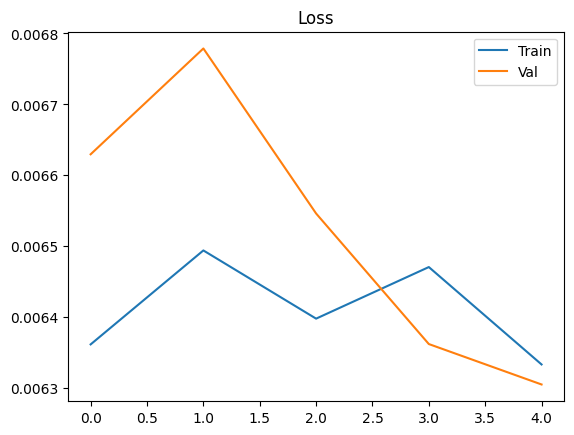

In [37]:
plt.plot(range(EPOCHS),train_loss,label ='Train')
plt.plot(range(EPOCHS),val_loss,label='Val')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Roc_Auc')

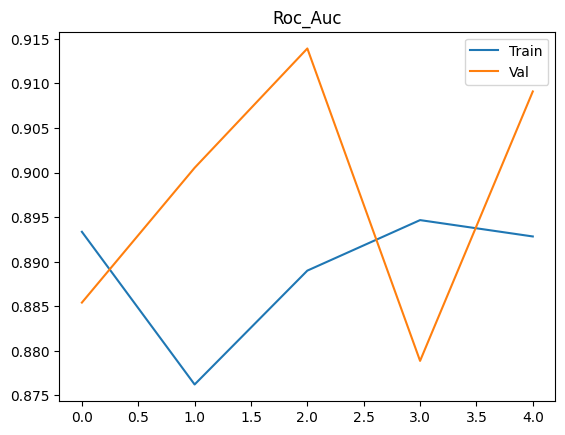

In [38]:
plt.plot(range(EPOCHS),train_auc,label ='Train')
plt.plot(range(EPOCHS),val_auc,label='Val')
plt.legend()
plt.title('Roc_Auc')

Text(0.5, 1.0, 'Roc_pAuc')

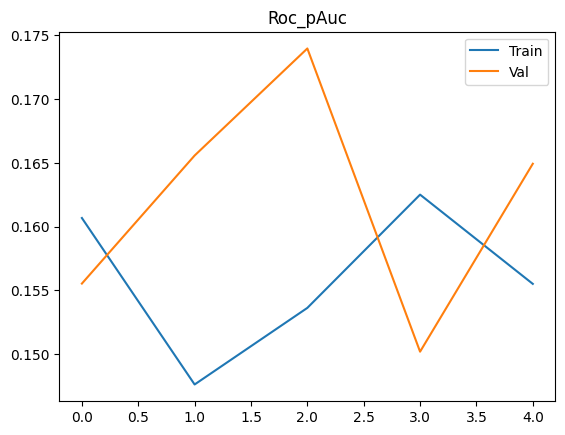

In [39]:
plt.plot(range(EPOCHS),train_pauc,label ='Train')
plt.plot(range(EPOCHS),val_pauc,label='Val')
plt.legend()
plt.title('Roc_pAuc')

In [40]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
full_model = FullModel()
full_model = full_model.to(DEVICE)
full_model.load_state_dict(torch.load('/kaggle/input/latest-state-dict/full_train_model2_epoch24loss0.007auc0.863pauc0.143.pth')['model_state_dict'])

optimizer = torch.optim.Adam(full_model.parameters())
optimizer.load_state_dict(torch.load('/kaggle/input/latest-state-dict/full_train_model2_epoch24loss0.007auc0.863pauc0.143.pth')['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=0, last_epoch=-1, verbose=False)
# loss_fn = FocalLoss()
loss_fn = nn.BCEWithLogitsLoss()
train_loss,val_loss,train_auc,val_auc,train_pauc,val_pauc,trained_model = train_model_full(full_model,full_train_loader,DEVICE,epochs=EPOCHS)

## Epoch: 0 ongoing ---------------


  0%|          | 0/12534 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.006586382165551186, Train auc: 0.8886152901475024, Train pauc: 0.15662377040446485
Saving model
## Epoch: 1 ongoing ---------------


  0%|          | 0/12534 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.0063378214836120605, Train auc: 0.895672972947879, Train pauc: 0.16208054683100218
Saving model
## Epoch: 2 ongoing ---------------


  0%|          | 0/12534 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.006289318203926086, Train auc: 0.8948104332495047, Train pauc: 0.16014395700370077
Saving model
## Epoch: 3 ongoing ---------------


  0%|          | 0/12534 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.006348641589283943, Train auc: 0.9011147965355241, Train pauc: 0.1634697255786672
Saving model
## Epoch: 4 ongoing ---------------


  0%|          | 0/12534 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.00627926317974925, Train auc: 0.8995904325659101, Train pauc: 0.16291997805841565
Saving model
